# Binary Classification of Insurance Cross Selling

**My Goal: The objective of this competition is to predict which customers respond positively to an automobile insurance offer.**

*Dataset Description:*

**id:** A unique identifier for each student.

**Gender:** The gender of the customer.

**Age:** The age of the customer.

**Driving_License:** Indicates whether the customer has a driver's license (1 = yes, 0 = no).

**Region_Code:** A unique code representing the customer's region.

**Previously_Insured:** Indicates whether the customer already has vehicle insurance (1 = yes, 0 = no).

**Vehicle_Age:** The age of the vehicle.

**Vehicle_Damage:** Indicates if the customer has had vehicle damage in the past (1 = yes, 0 = no).

**Annual_Premium:** The annual premium amount the customer needs to pay.

**Policy_Sales_Channel:** An anonymized code for various customer outreach channels, such as agents, email, phone calls, etc.

**Vintage:** The number of days the customer has been associated with the insurance company.

**Response:** The target variable indicating whether the customer is interested (1 = Interested, 0 = Not Interested).

# 1. Reading the dataset and getting some information

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# 2. Loading and Preparing the Data

In [2]:
train = pd.read_csv(r'C:\Users\isa.zeynalov\Desktop\Binary Classification of Insurance Cross Selling\train.csv')
test = pd.read_csv(r'C:\Users\isa.zeynalov\Desktop\Binary Classification of Insurance Cross Selling\test.csv')

In [3]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


**Dropping 'id' column as it's not needed for modeling**

In [4]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

# 3. Exploratory Data Analysis (EDA)

In [5]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Age,int64,11504798,66,0.000574,0,0.000000,38.383563,14.993459,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,int64,11504798,2,0.000017,0,0.000000,0.998022,0.044431,0.000000,1.000000,1.000000,1.000000,1.000000
Previously_Insured,int64,11504798,2,0.000017,0,0.000000,0.462997,0.498629,0.000000,0.000000,0.000000,1.000000,1.000000
Vintage,int64,11504798,290,0.002521,0,0.000000,163.897744,79.979531,10.000000,99.000000,166.000000,232.000000,299.000000
Response,int64,11504798,2,0.000017,0,0.000000,0.122997,0.328434,0.000000,0.000000,0.000000,0.000000,1.000000
Region_Code,float64,11504798,54,0.000469,0,0.000000,26.418690,12.991590,0.000000,15.000000,28.000000,35.000000,52.000000
Annual_Premium,float64,11504798,51728,0.449621,0,0.000000,30461.370411,16454.745205,2630.000000,25277.000000,31824.000000,39451.000000,540165.000000
Policy_Sales_Channel,float64,11504798,152,0.001321,0,0.000000,112.425442,54.035708,1.000000,29.000000,151.000000,152.000000,163.000000
Gender,object,11504798,2,0.000017,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Vehicle_Age,object,11504798,3,0.000026,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [6]:
# Repeat the description process for the test data
desc = pd.DataFrame(index = list(test))
desc['type'] = test.dtypes
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] /len(test) * 100
desc['null'] = test.isnull().sum()
desc['%null'] = desc['null'] / len(test) * 100
desc = pd.concat([desc,test.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Age,int64,7669866,66,0.000861,0,0.000000,38.391369,14.999507,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,int64,7669866,2,0.000026,0,0.000000,0.998021,0.044444,0.000000,1.000000,1.000000,1.000000,1.000000
Previously_Insured,int64,7669866,2,0.000026,0,0.000000,0.463077,0.498635,0.000000,0.000000,0.000000,1.000000,1.000000
Vintage,int64,7669866,290,0.003781,0,0.000000,163.899577,79.984449,10.000000,99.000000,166.000000,232.000000,299.000000
Region_Code,float64,7669866,53,0.000691,0,0.000000,26.426614,12.994326,0.000000,15.000000,28.000000,35.000000,52.000000
Annual_Premium,float64,7669866,50044,0.652476,0,0.000000,30465.525668,16445.864722,2630.000000,25280.000000,31827.000000,39460.000000,540165.000000
Policy_Sales_Channel,float64,7669866,151,0.001969,0,0.000000,112.364992,54.073585,1.000000,29.000000,151.000000,152.000000,163.000000
Gender,object,7669866,2,0.000026,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Vehicle_Age,object,7669866,3,0.000039,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Vehicle_Damage,object,7669866,2,0.000026,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [7]:
# Categorical variables analysis
categorical_columns = train.select_dtypes(include=['object']).columns
unique_counts = train[categorical_columns].nunique()
print(unique_counts)

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64


**Check value counts for specific columns:**

In [8]:
train.Gender.value_counts(normalize=True)

Gender
Male      0.541351
Female    0.458649
Name: proportion, dtype: float64

In [9]:
train.Vehicle_Damage.value_counts(normalize=True)

Vehicle_Damage
Yes    0.50268
No     0.49732
Name: proportion, dtype: float64

In [10]:
train.Vehicle_Age.value_counts(normalize=True)

Vehicle_Age
1-2 Year     0.520016
< 1 Year     0.438438
> 2 Years    0.041546
Name: proportion, dtype: float64

# 4. Visualizing Data Distributions

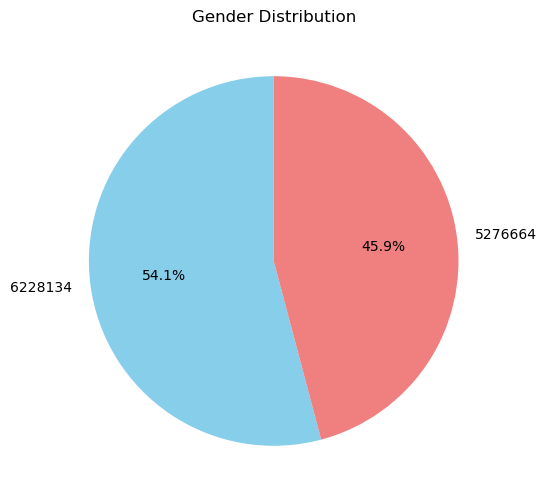

In [11]:
# Gender distribution
gender_counts = train['Gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Gender Distribution')
plt.show()

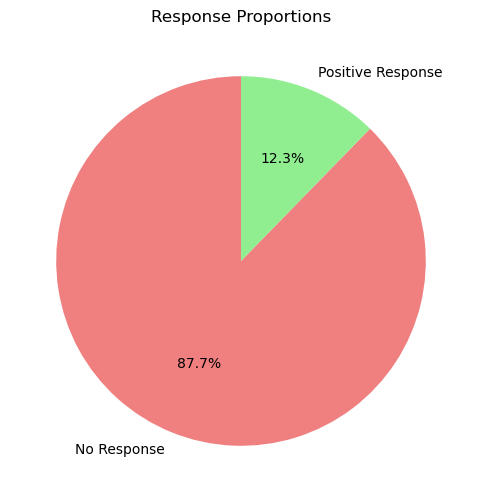

In [12]:
# Response proportions
response_counts = train['Response'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(response_counts, labels=['No Response', 'Positive Response'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Response Proportions')
plt.show()

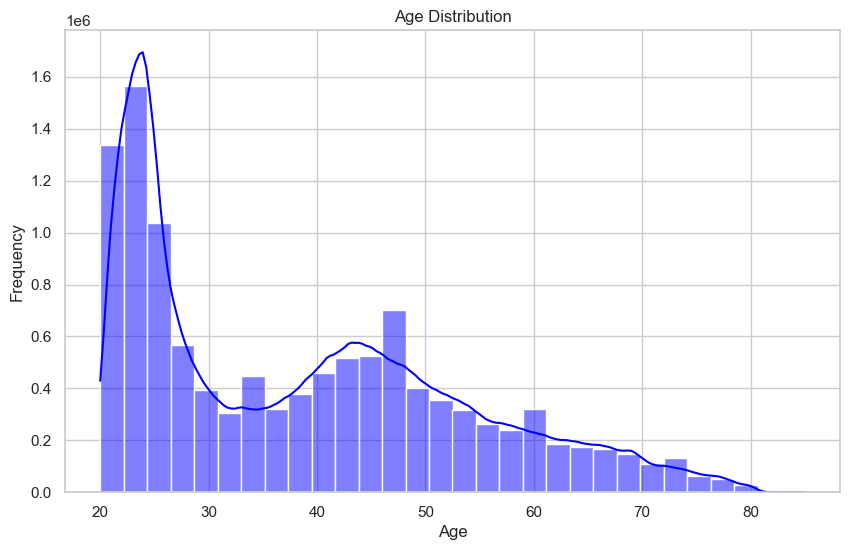

In [13]:
# Age distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

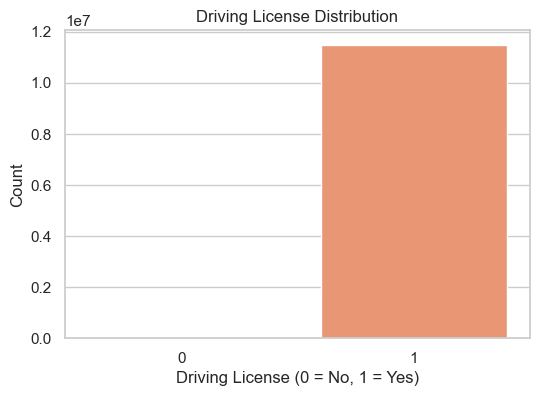

In [14]:
# Driving License distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Driving_License', data=train, palette='Set2')
plt.title('Driving License Distribution')
plt.xlabel('Driving License (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

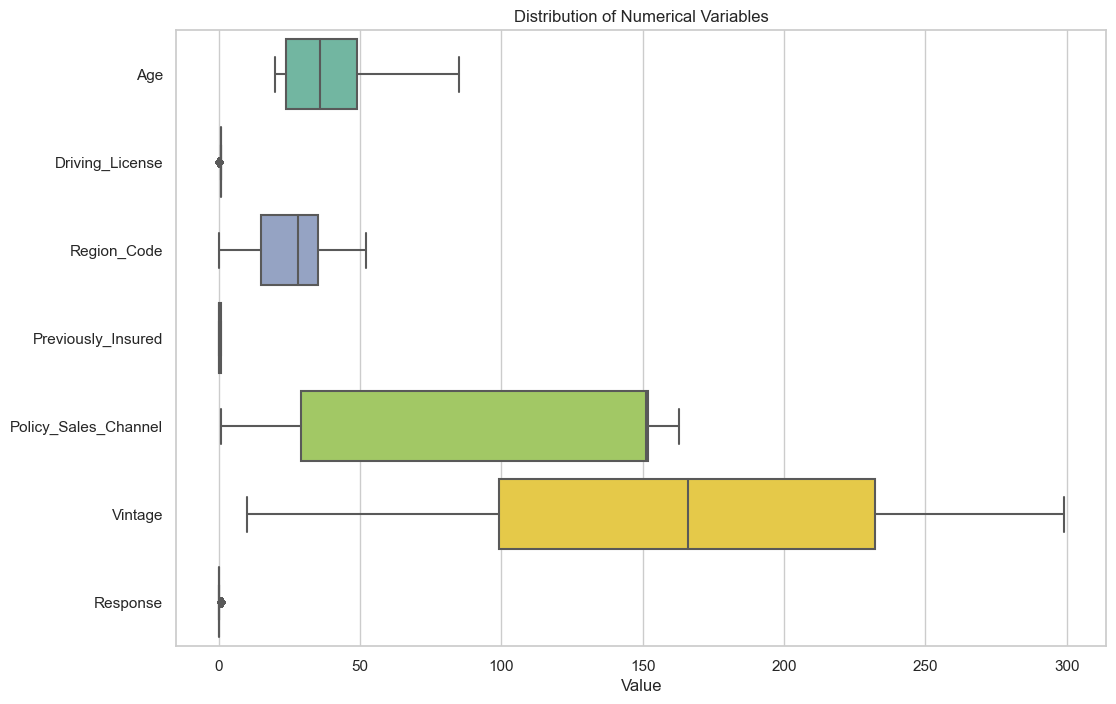

In [15]:
# Boxplot for numerical variables
numerical_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                  'Policy_Sales_Channel', 'Vintage', 'Response']
plt.figure(figsize=(12, 8))
sns.boxplot(data=train[numerical_cols], orient='h', palette='Set2')
plt.title('Distribution of Numerical Variables')
plt.xlabel('Value')
plt.show()

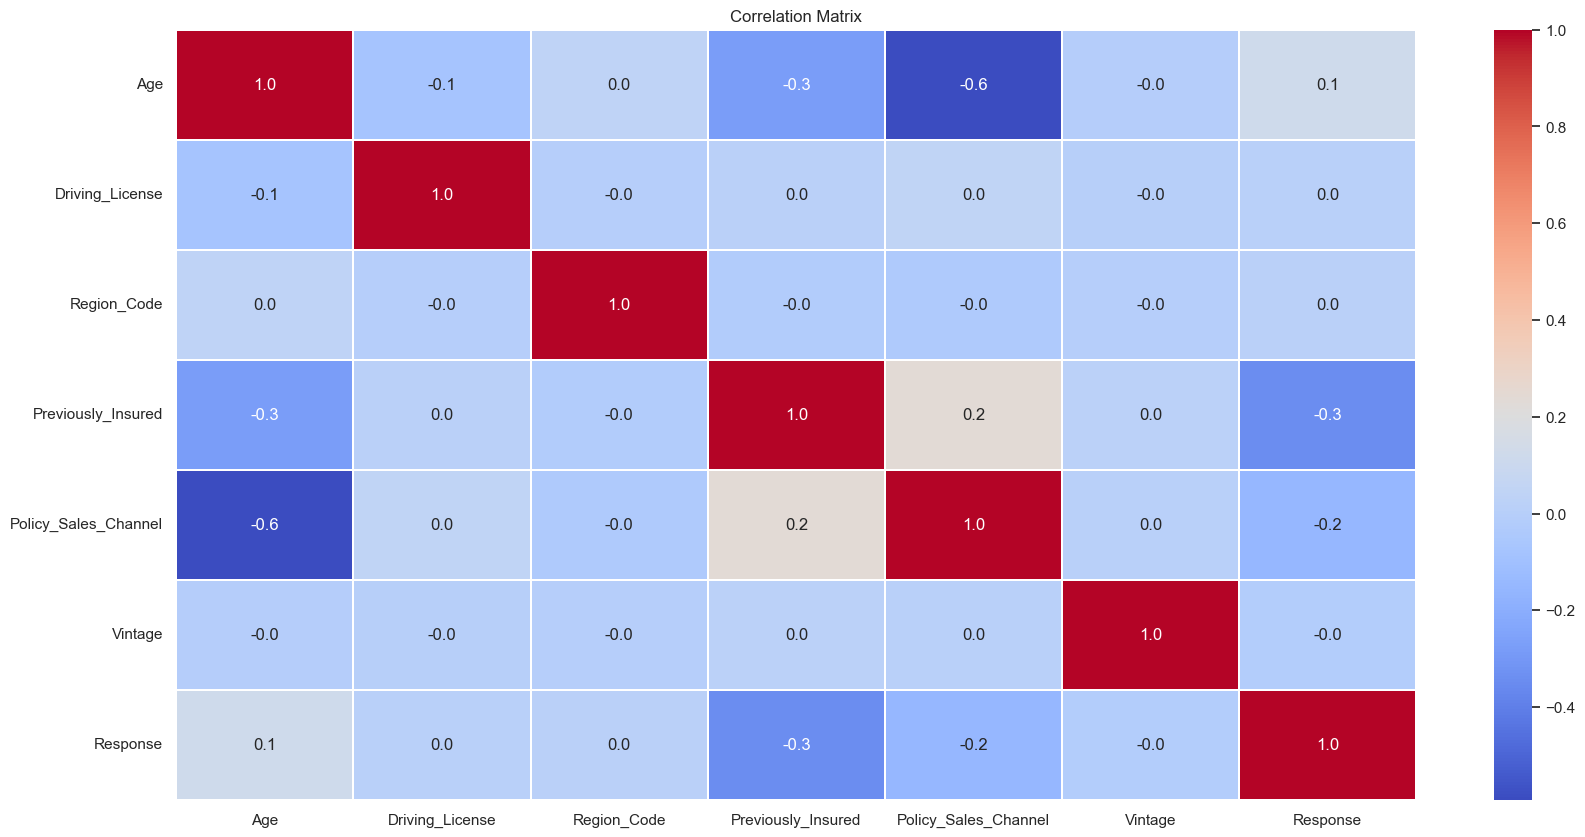

In [16]:
# Correlation matrix heatmap
correlation_matrix = train[numerical_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
#plt.gcf().set_facecolor('skyblue')  
plt.title('Correlation Matrix')
plt.show()

# 5. Data Preprocessing

In [17]:
# Function to convert Vehicle_Age to numerical values
def convert_vehicle_age(age_str):
    if isinstance(age_str, str):
        if '< 1 Year' in age_str:
            return 0
        elif '1-2 Year' in age_str:
            return 1
        elif '> 2 Years' in age_str:
            return 2
    return None

train['Vehicle_Age'] = train['Vehicle_Age'].apply(convert_vehicle_age)
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,2,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,0,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1,No,31951.0,152.0,294,0


In [18]:
# Encoding categorical variables
label_encoder = LabelEncoder()
train['Gender'] = label_encoder.fit_transform(train['Gender'])
test['Gender'] = label_encoder.fit_transform(test['Gender'])
train['Vehicle_Damage'] = label_encoder.fit_transform(train['Vehicle_Damage'])
test['Vehicle_Damage'] = label_encoder.fit_transform(test['Vehicle_Damage'])
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,21,1,35.0,0,1,1,65101.0,124.0,187,0
1,1,43,1,28.0,0,2,1,58911.0,26.0,288,1
2,0,25,1,14.0,1,0,0,38043.0,152.0,254,0
3,0,35,1,1.0,0,1,1,2630.0,156.0,76,0
4,0,36,1,15.0,1,1,0,31951.0,152.0,294,0


In [19]:
categorical_columns

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [20]:
train.corr()['Response']

Gender                  0.055212
Age                     0.122134
Driving_License         0.009197
Region_Code             0.012816
Previously_Insured     -0.345930
Vehicle_Age             0.231029
Vehicle_Damage          0.359780
Annual_Premium          0.032261
Policy_Sales_Channel   -0.152733
Vintage                -0.015177
Response                1.000000
Name: Response, dtype: float64

# 6. Splitting Data into Training and Testing Sets

In [21]:
# Separate features (X) and target variable (y)
X = train.loc[:, train.columns != "Response"]
y = train['Response']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# 7. Model Selection and Hyperparameter Tuning using Optuna

In [24]:
# Running the Optuna study for hyperparameter tuning
def objective(trial):
    model_type = trial.suggest_categorical("model_type", ["xgboost", "catboost"])

    if model_type == "xgboost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2)
        }
        model = XGBClassifier(**params, random_state=101, use_label_encoder=False, eval_metric='auc')

    elif model_type == "catboost":
        params = {
            'iterations': trial.suggest_int('iterations', 50, 100),
            'depth': trial.suggest_int('depth', 3, 6),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.2)
        }
        model = CatBoostClassifier(**params, random_state=101, verbose=0)

    auc = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return auc

# Running the Optuna study for hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-08-23 14:40:24,859] A new study created in memory with name: no-name-1fa0e8a7-2797-4c05-a7c0-19ade7a4aac0
[I 2024-08-23 14:44:12,600] Trial 0 finished with value: 0.8725023737291616 and parameters: {'model_type': 'xgboost', 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.16907630300652354}. Best is trial 0 with value: 0.8725023737291616.
[I 2024-08-23 14:47:47,090] Trial 1 finished with value: 0.858000907248663 and parameters: {'model_type': 'catboost', 'iterations': 65, 'depth': 3, 'learning_rate': 0.09891889916616949}. Best is trial 0 with value: 0.8725023737291616.
[I 2024-08-23 14:52:56,659] Trial 2 finished with value: 0.8693148179892555 and parameters: {'model_type': 'xgboost', 'n_estimators': 95, 'max_depth': 6, 'learning_rate': 0.07400982408745661}. Best is trial 0 with value: 0.8725023737291616.
[I 2024-08-23 14:56:19,465] Trial 3 finished with value: 0.8651265843667634 and parameters: {'model_type': 'xgboost', 'n_estimators': 60, 'max_depth': 5, 'learning_rate'

In [25]:
# Retrieve the best parameters
best_params = study.best_params
best_model_type = best_params.pop("model_type")

# Selecting the best model based on Optuna results
if best_model_type == "xgboost":
    best_model = XGBClassifier(**best_params, random_state=101, use_label_encoder=False, eval_metric='auc')
elif best_model_type == "catboost":
    best_model = CatBoostClassifier(**best_params, random_state=101, verbose=0)

best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_test)[:, 1]

In [ ]:
print("")

# 8. Model Training and Evaluation

In [26]:
# Training the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_test)[:, 1]

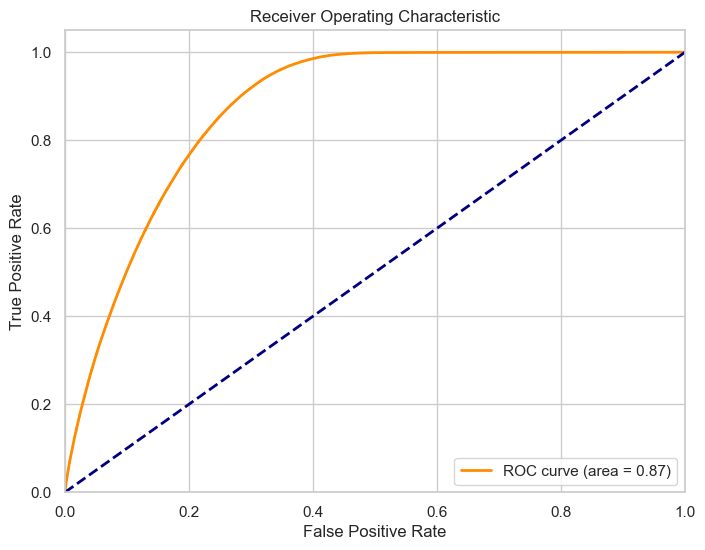

In [27]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 9. Final Model Training and Scoring

In [28]:
# Fit the best model to the entire training data
best_model.fit(X_train, y_train)

# Predict the probabilities for the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final Model's ROC AUC Score: {roc_auc:.4f}")

Final Model's ROC AUC Score: 0.8743


In [29]:
# Print the best model and its parameters
print(f"Best Model: {best_model_type}")
print(f"Best Parameters: {best_params}")
print(f"Final Model's ROC AUC Score: {roc_auc:.4f}")

Best Model: xgboost
Best Parameters: {'n_estimators': 64, 'max_depth': 6, 'learning_rate': 0.19831390716021402}
Final Model's ROC AUC Score: 0.8743
